In [1]:
# General Libraries
import matplotlib.pyplot as plt
%matplotlib widget
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import importlib
import random
from tqdm import tqdm

synchron_ad = importlib.import_module('synchron_ad')
utilities = importlib.import_module('utilities')
synchronization_utils = importlib.import_module('synchronization_heads.synchronization_utils')

WIDTH = 20
HEIGHT = 4

In [2]:
PARAMS = {
    "device": "mps",
    "seed": 1995,
    "batch_size": 128,
    "epochs": 150,
    "lr": 1e-4,
    "patience": 150,
    "valid_size": 0.1,
    "normalisation": "std_window",
    "machine": "BrushlessMotor",
    "sensors": ["imp23absu_mic", "ism330dhcx_acc", "ism330dhcx_gyro"],
}

train_data_loader, valid_data_loader, test_data_loader, Y_test, NUM_CHANNELS, WINDOW_LENGTHS = utilities.initialise_dataloaders(
    PARAMS)

In [5]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, kernel_size=5, stride=5):
        super(EncoderDecoderModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=4,
                        out_channels=4,
                        kernel_size=1,
                        stride=1),
            nn.Conv1d(
                in_channels=4,
                out_channels=8,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Conv1d(
                in_channels=8,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(
                in_channels=32,
                out_channels=64,
                kernel_size=kernel_size,
                stride=stride,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(
                in_channels=64,
                out_channels=2,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.AdaptiveAvgPool1d(1)
        )

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=128,
                out_channels=64,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.ConvTranspose1d(
                in_channels=64,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.ConvTranspose1d(
                in_channels=32,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.ConvTranspose1d(
                in_channels=16,
                out_channels=8,
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.ConvTranspose1d(
                in_channels=8,
                out_channels=1,
                kernel_size=kernel_size,
                stride=stride
            )
        )
    
        self.projection = nn.Linear(2, 5836)
    
    def forward(self, x):
        x = self.encoder(x).flatten(1)
        #x = self.decoder(x)
        x = self.projection(x)
        return x

# Instantiate the model
model = EncoderDecoderModel()


In [6]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Set the random seed for reproducibility
random.seed(PARAMS['seed'])
np.random.seed(PARAMS['seed'])
torch.manual_seed(PARAMS['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(PARAMS['seed'])


# Move model to the specified device
device = torch.device(PARAMS['device'])
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['lr'])

# Define the loss function
criterion = nn.MSELoss()

# Predefine the main position encoding vector
main_pos_enc = torch.concat([torch.linspace(0, 1, WINDOW_LENGTHS[sensor]) for sensor in PARAMS['sensors'] for _ in range(NUM_CHANNELS[sensor])], dim=0).unsqueeze(0).unsqueeze(1).to(device).float()

# Predefine the sensor ID encoding vector
sensor_id_enc = torch.concat(
    [
        torch.full((WINDOW_LENGTHS[sensor],), idx)  # Tensor filled with sensor's index
        for idx, sensor in enumerate(PARAMS['sensors'])  # Track sensor index
        for _ in range(NUM_CHANNELS[sensor])  # Repeat for each channel
    ],
    dim=0
).unsqueeze(0).unsqueeze(1).to(device).float()





# Predefine the channel ID encoding vector
channel_enc_blocks = []
current_channel = 0  # Track the global channel index

# Build encoding blocks
for sensor in PARAMS['sensors']:
    # Create one block per channel in this sensor
    for _ in range(NUM_CHANNELS[sensor]):
        # Create tensor filled with current_channel value
        block = torch.full((WINDOW_LENGTHS[sensor],), current_channel)
        channel_enc_blocks.append(block)
        current_channel += 1  # Increment global channel counter

# Combine all blocks and match main_pos_enc's dimensions
channel_id_enc = torch.cat(channel_enc_blocks, dim=0).unsqueeze(0).unsqueeze(1).to(device).float()



# Normalise all encoding vectors
main_pos_enc = (main_pos_enc - main_pos_enc.mean()) / main_pos_enc.std()
sensor_id_enc = (sensor_id_enc - sensor_id_enc.mean()) / sensor_id_enc.std()
channel_id_enc = (channel_id_enc - channel_id_enc.mean()) / channel_id_enc.std()


# Early stopping parameters
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'

# Training loop
for epoch in range(PARAMS['epochs']):
    model.train()
    running_loss = 0.0
    train_loader = tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{PARAMS['epochs']}", leave=False)
    for batch_idx, batch in enumerate(train_loader):
        # Move batch to the specified device
        batch = [b.to(device) for b in batch]
        
        # Prepare the input and target tensors
        batch_vec = torch.concat([b.flatten(1) for b in batch], dim=1)
        pos_enc = main_pos_enc.repeat(batch_vec.shape[0], 1, 1)
        sensor_enc = sensor_id_enc.repeat(batch_vec.shape[0], 1, 1)
        channel_enc = channel_id_enc.repeat(batch_vec.shape[0], 1, 1)


        batch_vec_emb = torch.concat([batch_vec.unsqueeze(1), pos_enc, sensor_enc, channel_enc], dim=1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        #outputs = model(batch_vec.unsqueeze(1))
        outputs = model(batch_vec_emb)

        # Compute the loss
        loss = criterion(outputs, batch_vec)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()
        train_loader.set_postfix(loss=running_loss/(batch_idx+1))
    
    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    valid_loader = tqdm(valid_data_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_loader):
            # Move batch to the specified device
            batch = [b.to(device) for b in batch]
            
            # Prepare the input and target tensors
            batch_vec = torch.concat([b.flatten(1) for b in batch], dim=1)
            pos_enc = main_pos_enc.repeat(batch_vec.shape[0], 1, 1)
            sensor_enc = sensor_id_enc.repeat(batch_vec.shape[0], 1, 1)
            channel_enc = channel_id_enc.repeat(batch_vec.shape[0], 1, 1)


            batch_vec_emb = torch.concat([batch_vec.unsqueeze(1), pos_enc, sensor_enc, channel_enc], dim=1)
            
            # Forward pass
            #outputs = model(batch_vec.unsqueeze(1))
            outputs = model(batch_vec_emb)
            
            # Compute the loss
            loss = criterion(outputs, batch_vec)
            
            # Accumulate the loss
            val_loss += loss.item()
            valid_loader.set_postfix(val_loss=val_loss/(batch_idx+1))
    
    # Store the average training and validation loss for this epoch
    train_losses.append(running_loss/len(train_data_loader))
    val_losses.append(val_loss/len(valid_data_loader))
    
    # Print the average training and validation loss for this epoch
    print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Loss: {running_loss/len(train_data_loader):.4f}, Val Loss: {val_loss/len(valid_data_loader):.4f}')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= PARAMS['patience']:
            print("Early stopping triggered")
            break

# Load the best model state
model.load_state_dict(torch.load(best_model_path))

Epoch [1/150], Loss: 1.1609, Val Loss: 1.1362


Epoch [2/150], Loss: 1.1225, Val Loss: 1.1089


Epoch [3/150], Loss: 1.0946, Val Loss: 1.0801


Epoch [4/150], Loss: 1.0668, Val Loss: 1.0545


Epoch [5/150], Loss: 1.0444, Val Loss: 1.0354


Epoch [6/150], Loss: 1.0284, Val Loss: 1.0223


Epoch [7/150], Loss: 1.0177, Val Loss: 1.0136


Epoch [8/150], Loss: 1.0106, Val Loss: 1.0079


Epoch [9/150], Loss: 1.0061, Val Loss: 1.0044


Epoch [10/150], Loss: 1.0033, Val Loss: 1.0023


Epoch [11/150], Loss: 1.0016, Val Loss: 1.0010


Epoch [12/150], Loss: 1.0006, Val Loss: 1.0003


Epoch [13/150], Loss: 1.0001, Val Loss: 0.9999


Epoch [14/150], Loss: 0.9998, Val Loss: 0.9997


Epoch [15/150], Loss: 0.9997, Val Loss: 0.9996


Epoch [16/150], Loss: 0.9996, Val Loss: 0.9995


Epoch [17/150], Loss: 0.9996, Val Loss: 0.9995


Epoch [18/150], Loss: 0.9995, Val Loss: 0.9995


Epoch [19/150], Loss: 0.9995, Val Loss: 0.9995


KeyboardInterrupt: 

In [ ]:
# plot encodings 

plt.figure(figsize=(WIDTH, HEIGHT))
plt.plot(main_pos_enc.squeeze().cpu().numpy())
plt.plot(sensor_id_enc.squeeze().cpu().numpy())
plt.plot(channel_id_enc.squeeze().cpu().numpy())

In [ ]:
# Create a dataframe to store the training and validation losses
losses_df = pd.DataFrame({
    'train': train_losses,
    'valid': val_losses
})

# Display the dataframe
print(losses_df)
# Save the dataframe to a CSV file
losses_df.to_csv('more_norm_emb_with_pos_emb_losses_conv.csv', index=False)

In [ ]:
with_pos_emb_losses['valid'].min(), without_pos_emb_losses['valid'].min(), sine_with_pos_emb_losses['valid'].min()

In [ ]:
# Read the CSV files
with_pos_emb_losses = pd.read_csv('with_pos_emb_losses_conv.csv')
without_pos_emb_losses = pd.read_csv('without_pos_emb_losses_conv.csv')
more_emb_with_pos_emb_losses = pd.read_csv('more_emb_with_pos_emb_losses_conv.csv')
more_norm_emb_with_pos_emb_losses = pd.read_csv('more_norm_emb_with_pos_emb_losses_conv.csv')

# Plot the losses over epochs for without_pos_emb_losses_conv
plt.figure(figsize=(WIDTH, HEIGHT))

plt.plot(without_pos_emb_losses['train'], label='Without Pos Emb Train', color='red')
plt.plot(without_pos_emb_losses['valid'], label='Without Pos Emb Valid', color='red', linestyle='dashed')

plt.plot(with_pos_emb_losses['train'], label='With Pos Emb Train', color='blue')
plt.plot(with_pos_emb_losses['valid'], label='With Pos Emb Valid', color='blue', linestyle='dashed')

plt.plot(more_emb_with_pos_emb_losses['train'], label='More Emb With Pos Emb Train', color='green')
plt.plot(more_emb_with_pos_emb_losses['valid'], label='More Emb With Pos Emb Valid', color='green', linestyle='dashed')

plt.plot(more_norm_emb_with_pos_emb_losses['train'], label='More Norm Emb With Pos Emb Train', color='purple')
plt.plot(more_norm_emb_with_pos_emb_losses['valid'], label='More Norm Emb With Pos Emb Valid', color='purple', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Initialize lists to store input, output vectors, and embeddings
input_vectors = []
output_vectors = []
embeddings = []

# Iterate through the test data loader
model.eval()
test_loader = tqdm(test_data_loader, desc="Testing", leave=False)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        # Move batch to the specified device
        batch = [b.to(device) for b in batch]
        
        # Prepare the input tensor
        batch_vec = torch.concat([b.flatten(1) for b in batch], dim=1)
        pos_enc = torch.sin(main_pos_enc.repeat(batch_vec.shape[0], 1, 1))
        sensor_enc = sensor_id_enc.repeat(batch_vec.shape[0], 1, 1)
        channel_enc = channel_id_enc.repeat(batch_vec.shape[0], 1, 1)
        batch_vec_emb = torch.concat([batch_vec.unsqueeze(1), pos_enc, sensor_enc, channel_enc], dim=1)
        
        # Forward pass to get the output and embeddings
        encoded = model.encoder(batch_vec_emb)
        outputs = model(batch_vec_emb)
        
        # Append the input, output vectors, and embeddings to the lists
        input_vectors.append(batch_vec.cpu())
        output_vectors.append(outputs.cpu())
        embeddings.append(encoded.cpu())

# Concatenate all input, output vectors, and embeddings
input_vectors = torch.concat(input_vectors, dim=0)
output_vectors = torch.concat(output_vectors, dim=0)
embeddings = torch.concat(embeddings, dim=0).flatten(1)

# Now input_vectors, output_vectors, and embeddings are ready for visualization

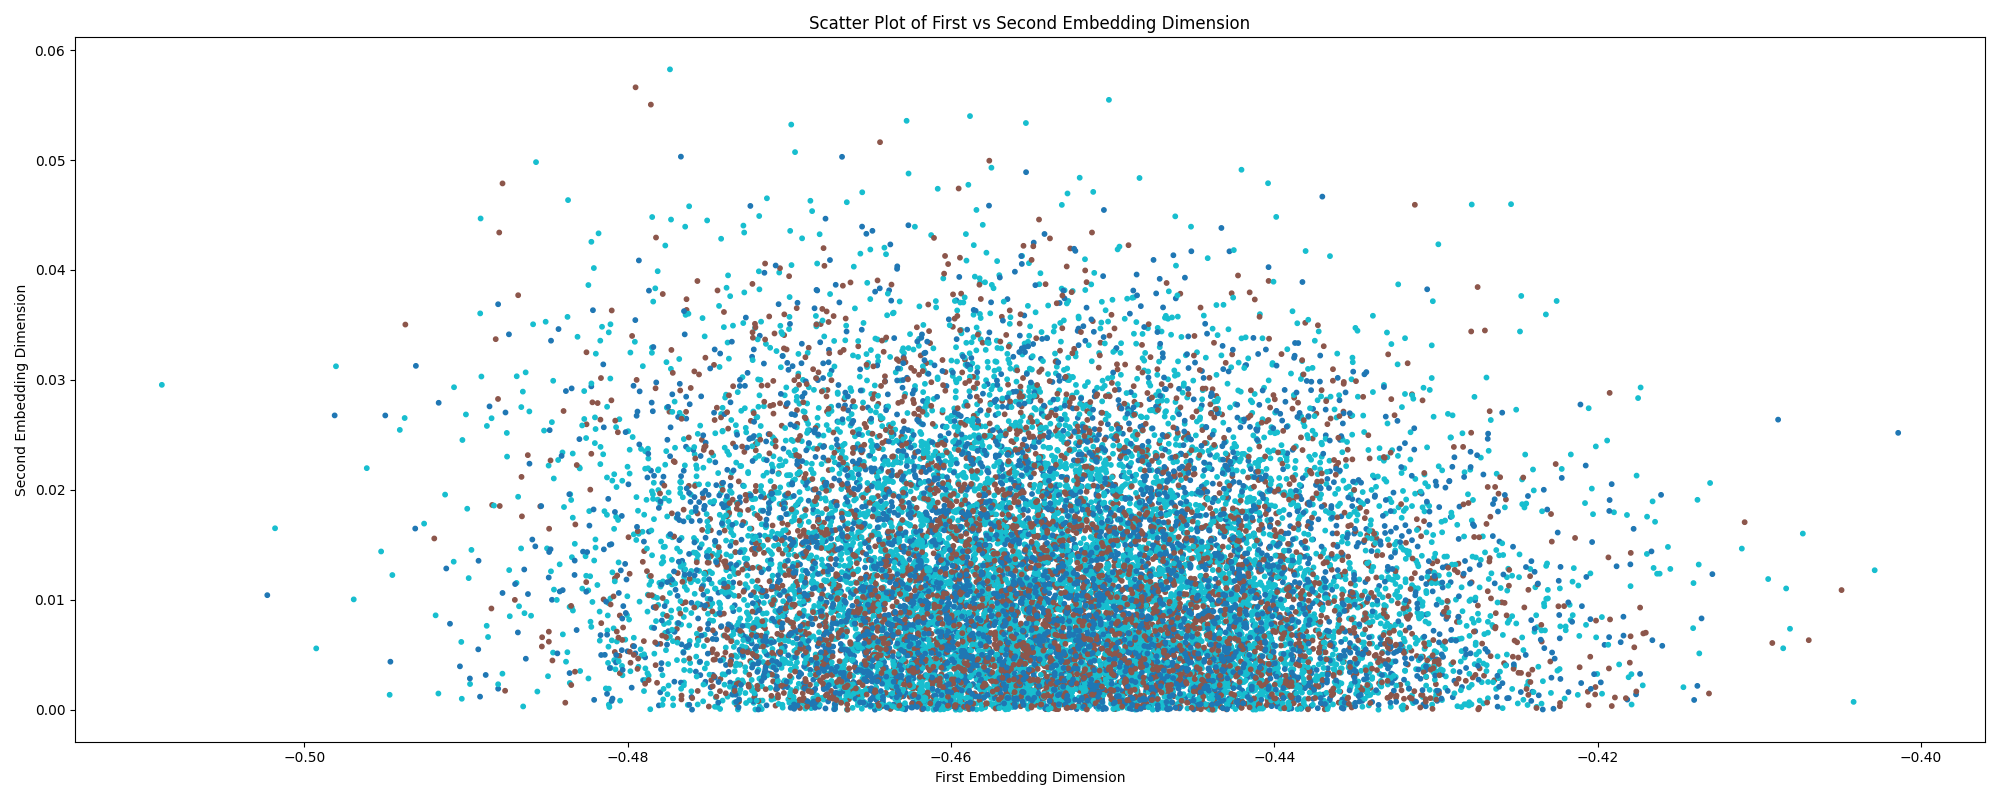

In [8]:
# Convert embeddings and labels to numpy arrays
embeddings_np = embeddings.cpu().numpy()
labels_np = Y_test['anomaly_label'].values

# Create a color map for the labels
unique_labels = np.unique(labels_np)
colors = plt.get_cmap('tab10', len(unique_labels))

# Create a dictionary to map labels to colors
label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

# Map the labels to colors
label_colors = [label_to_color[label] for label in labels_np]

a = embeddings_np.mean(axis=1)
b = embeddings_np.std(axis=1)

# Plot the scatter plot
plt.figure(figsize=(WIDTH,2* HEIGHT))
plt.scatter(a, b, c=label_colors, alpha=1, s=10)
plt.xlabel('First Embedding Dimension')
plt.ylabel('Second Embedding Dimension')
plt.title('Scatter Plot of First vs Second Embedding Dimension')
plt.tight_layout()
plt.show()

In [ ]:
import random

# Select a random index
random_index = random.randint(0, input_vectors.shape[0] - 1)

# Get the input and output vectors for the selected index
input_sample = input_vectors[random_index].numpy()
output_sample = output_vectors[random_index].numpy()

# Plot the input and output vectors
plt.figure(figsize=(WIDTH, HEIGHT))

plt.plot(input_sample, label='Input Sample')
plt.plot(output_sample, label='Output Sample')
plt.title('Input and Output Sample')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
Y_test['score'] =((output_vectors - input_vectors) ** 2).mean(axis=1)

In [ ]:
Y_test['combined_label']

In [ ]:
utilities.calculate_single_auc(Y_test, 'score')

In [ ]:
Y_test_grouped = utilities.group_by_segment_id(Y_test, ['score'])
utilities.calculate_single_auc(Y_test_grouped, 'score')